In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [4]:
plt.rcParams.update({
    "font.family":       "serif",
    "font.size":         12,
    "axes.spines.top":   False,
    "axes.spines.right": False,
    "axes.linewidth":    0.8,
    "grid.color":        "#e0e0e0",
    "grid.linewidth":    0.6,
    "lines.linewidth":   2.0,
})

C = {"n2": "#2166ac", "n10": "#d6604d", "n100": "#4dac26"}   # colourblind-safe

# Sphere + ellipsoid
def sphere(x):    return np.sum(x**2)
def ellipsoid(x): return np.sum(np.arange(1, len(x)+1) * x**2)

# Self-adaptive (μ+λ)-ES
def self_adaptive_es(dim, mu, lmbda, fitness_fn=sphere,
                     generations=500, sigma_init=1.0,
                     track_per_dim=False):
    tau_g = 1.0 / np.sqrt(2 * dim)
    tau_l = 1.0 / np.sqrt(2 * np.sqrt(dim))

    pop = [(np.random.uniform(-5, 5, dim), np.full(dim, sigma_init))
           for _ in range(mu)]

    fit_hist   = np.empty(generations)
    sigma_hist = np.empty(generations)
    sigma_dims = [] if track_per_dim else None

    for t in range(generations):
        offspring = []
        for _ in range(lmbda):
            x1, s1 = pop[np.random.randint(mu)]
            x2, s2 = pop[np.random.randint(mu)]
            sc = np.maximum(
                0.5*(s1+s2) * np.exp(tau_g*np.random.randn()
                                     + tau_l*np.random.randn(dim)), 1e-10)
            xc = 0.5*(x1+x2) + sc * np.random.randn(dim)
            offspring.append((xc, sc))

        pool    = pop + offspring
        fitness = np.array([fitness_fn(p[0]) for p in pool])
        best    = np.argsort(fitness)[:mu]
        pop     = [pool[i] for i in best]

        fit_hist[t]   = fitness[best[0]]
        sigma_hist[t] = np.mean(pop[0][1])
        if track_per_dim:
            sigma_dims.append(pop[0][1].copy())

    return fit_hist, sigma_hist, sigma_dims

DIMS    = [2, 10, 100]
GENS    = 500
N_RUNS  = 15
MU_LAM  = {2: (5, 20), 10: (10, 60), 100: (50, 400)}
np.random.seed(42)

# (b)sphere across dimensions 
results = {}
for dim in DIMS:
    mu, lam = MU_LAM[dim]
    runs = [self_adaptive_es(dim, mu, lam)[:2] for _ in range(N_RUNS)]
    fh = np.array([r[0] for r in runs])
    sh = np.array([r[1] for r in runs])
    results[dim] = fh.mean(0), fh.std(0), sh.mean(0), sh.std(0)
    print(f"n={dim:>3}  final fitness {fh[:,-1].mean():.2e} ± {fh[:,-1].std():.2e}")

# per-dim σ on ellipsoid, n=10 
dim, mu, lam = 10, 10, 60
sdh_runs = []
for _ in range(N_RUNS):
    _, _, sdh = self_adaptive_es(dim, mu, lam, fitness_fn=ellipsoid,
                                  track_per_dim=True)
    sdh_runs.append(sdh)
sdh_mean = np.array(sdh_runs).mean(0)   # (gens, dim)

gens   = np.arange(GENS)
labels = {2: "n=2", 10: "n=10", 100: "n=100"}
colors = {2: C["n2"], 10: C["n10"], 100: C["n100"]}

print("Done.\n")

n=  2  final fitness 4.52e-24 ± 3.19e-24
n= 10  final fitness 1.26e-20 ± 2.19e-21
n=100  final fitness 2.32e-15 ± 4.41e-15
Done.



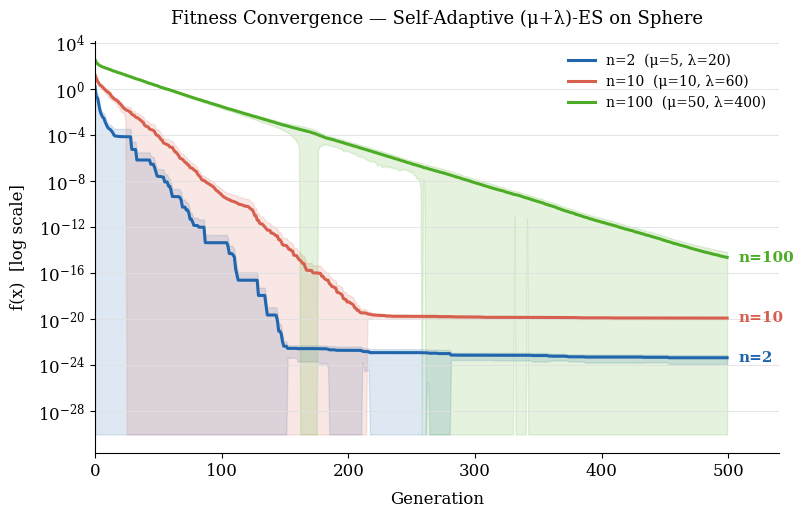

Figure 1 saved.


In [ ]:
# fig 1 —c fit convergence 
fig, ax = plt.subplots(figsize=(9, 5.5))
fig.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.13)

for dim in DIMS:
    fm, fs, _, _ = results[dim]
    mu, lam = MU_LAM[dim]
    col = colors[dim]
    ax.semilogy(gens, fm, color=col, linewidth=2.2,
                label=f"n={dim}  (μ={mu}, λ={lam})")
    ax.fill_between(gens, np.maximum(fm-fs, 1e-30), fm+fs,
                    alpha=0.15, color=col)
for dim in DIMS:
    fm, _, _, _ = results[dim]
    ax.annotate(f"n={dim}", xy=(GENS-1, fm[-1]),
                xytext=(8, 0), textcoords="offset points",
                color=colors[dim], fontsize=11, va="center", fontweight="bold")
ax.set_xlabel("Generation", labelpad=8)
ax.set_ylabel("f(x)  [log scale]", labelpad=8)
ax.set_title("Fitness Convergence — Self-Adaptive (μ+λ)-ES on Sphere",
             fontsize=13, pad=12)
ax.legend(frameon=False, fontsize=10, loc="upper right")
ax.grid(True, which="major", axis="y")
ax.set_xlim(0, GENS + 40)
plt.show()
plt.close()
print("Figure 1 saved.")

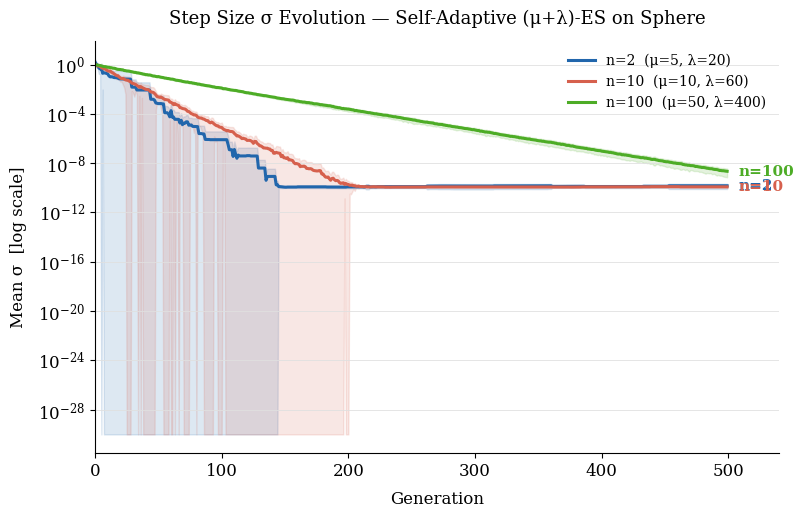

Figure 2 saved.


In [6]:
# fig 2 — σ convergence 
fig, ax = plt.subplots(figsize=(9, 5.5))
fig.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.13)

for dim in DIMS:
    _, _, sm, ss = results[dim]
    col = colors[dim]
    mu, lam = MU_LAM[dim]
    ax.semilogy(gens, sm, color=col, linewidth=2.2,
                label=f"n={dim}  (μ={mu}, λ={lam})")
    ax.fill_between(gens, np.maximum(sm-ss, 1e-30), sm+ss,
                    alpha=0.15, color=col)

for dim in DIMS:
    _, _, sm, _ = results[dim]
    ax.annotate(f"n={dim}", xy=(GENS-1, sm[-1]),
                xytext=(8, 0), textcoords="offset points",
                color=colors[dim], fontsize=11, va="center", fontweight="bold")
ax.set_xlabel("Generation", labelpad=8)
ax.set_ylabel("Mean σ  [log scale]", labelpad=8)
ax.set_title("Step Size σ Evolution — Self-Adaptive (μ+λ)-ES on Sphere",
             fontsize=13, pad=12)
ax.legend(frameon=False, fontsize=10, loc="upper right")
ax.grid(True, which="major", axis="y")
ax.set_xlim(0, GENS + 40)
plt.show()
plt.close()
print("Figure 2 saved.")

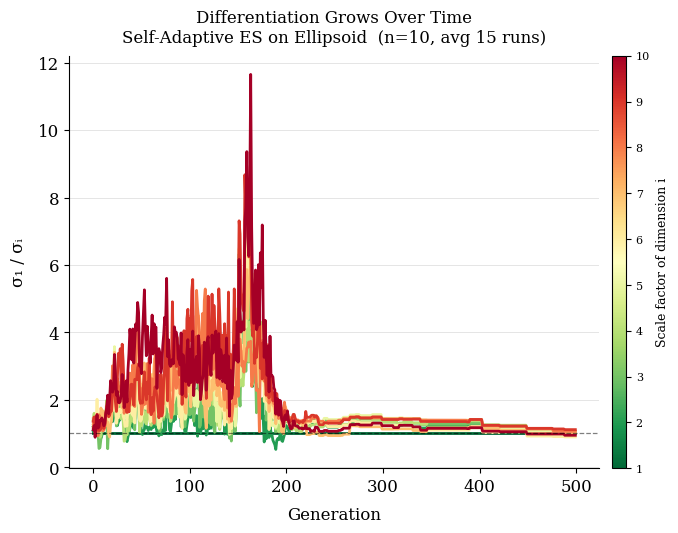

In [11]:
# fig 3 — Per-dimension σ ratio: σ_1 / σ_i over time 
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(9, 5.5))
fig.subplots_adjust(left=0.11, right=0.82, top=0.88, bottom=0.13)

dim10_cmap = plt.colormaps["RdYlGn_r"].resampled(10)

for i in range(10):
    ratio = sdh_mean[:, 0] / sdh_mean[:, i]
    ax.plot(gens, ratio, color=dim10_cmap(i/9), linewidth=2.0,
            label=f"σ₁/σ_{i+1}  (scale={i+1})")

ax.axhline(1.0, color="black", linewidth=0.9, linestyle="--", alpha=0.5)
ax.set_xlabel("Generation", labelpad=8)
ax.set_ylabel("σ₁ / σᵢ", labelpad=8)
ax.set_title("Differentiation Grows Over Time\n"
             "Self-Adaptive ES on Ellipsoid  (n=10, avg 15 runs)",
             fontsize=12, pad=10)
ax.grid(True, which="major", axis="y")
sm_cb = mpl.cm.ScalarMappable(cmap="RdYlGn_r",
                                norm=mpl.colors.Normalize(vmin=1, vmax=10))
cb = plt.colorbar(sm_cb, ax=ax, pad=0.02, aspect=30)
cb.set_label("Scale factor of dimension i", fontsize=9)
cb.ax.tick_params(labelsize=8)
plt.show()
plt.close()

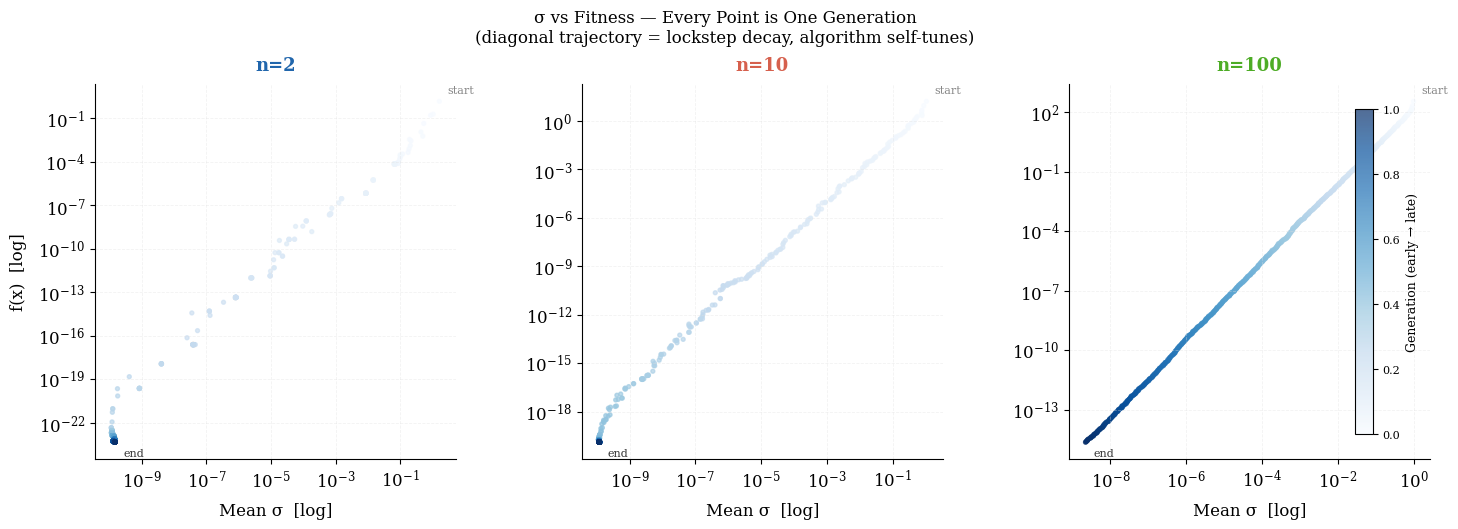

Figure 4 saved.


In [ ]:
# fig 4 — σ vs fit: the lockstep rel 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.subplots_adjust(left=0.08, right=0.97, top=0.88, bottom=0.13, wspace=0.35)
for ax, dim in zip(axes, DIMS):
    fm, _, sm, _ = results[dim]
    col = colors[dim]
    gen_norm = gens / GENS
    sc = ax.scatter(sm, fm, c=gen_norm, cmap="Blues", s=8,
                    alpha=0.7, vmin=0, vmax=1)
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_xlabel("Mean σ  [log]", labelpad=8)
    ax.set_ylabel("f(x)  [log]" if dim == 2 else "", labelpad=8)
    ax.set_title(f"n={dim}", fontsize=13, color=col, fontweight="bold", pad=10)
    ax.grid(True, which="major", linestyle="--", alpha=0.4)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.annotate("start", xy=(sm[0], fm[0]), xytext=(6, 6),
                textcoords="offset points", fontsize=8, color="#888888")
    ax.annotate("end",   xy=(sm[-1], fm[-1]), xytext=(6, -10),
                textcoords="offset points", fontsize=8, color="#333333")
cax = fig.add_axes([0.92, 0.18, 0.012, 0.65])
cb  = plt.colorbar(sc, cax=cax)
cb.set_label("Generation (early → late)", fontsize=9)
cb.ax.tick_params(labelsize=8)

fig.suptitle("σ vs Fitness — Every Point is One Generation\n"
             "(diagonal trajectory = lockstep decay, algorithm self-tunes)",
             fontsize=12, y=1.03)
plt.show()
plt.close()
print("Figure 4 saved.")